# 目的
前回の続き。

# 前回保存したデータのテスト

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import os
import pickle
import pandas as pd
import numpy as np
import datetime

from FX.FX import SQLAnaforFX
from FX.FX import drawfigfunc as dff
from FX.FX import datetimefuncs as dtf
from FX.FX import analyzefuncs as af
from FX.FX import KerasModelAdapter

Using TensorFlow backend.


In [2]:
adapter2 = KerasModelAdapter()
adapter2.load("./data/model_20170530/")

In [3]:
model = adapter2.model()

In [9]:
"""DBの読み込み"""
dbpath = "201704"
sql = SQLAnaforFX(dbpath)
sql.showtablenames()

"""OHLC"""
close = sql.toDataFrame("ask01min", colselect=["close"]).as_matrix()[:,0]
opens = sql.toDataFrame("ask01min", colselect=["open"]).as_matrix()[:,0]
high = sql.toDataFrame("ask01min", colselect=["high"]).as_matrix()[:,0]
low = sql.toDataFrame("ask01min", colselect=["low"]).as_matrix()[:,0]
ohlc = np.vstack((opens, high, low, close))
oc = np.vstack((opens, close)).T

dclose = np.zeros_like(close)
dclose[1:] = np.diff(close)

"""Spread"""
close_bid = sql.toDataFrame("bid01min", colselect=["close"]).as_matrix()[:,0]
s = np.mean((close - close_bid)[close != 0])
close_ask = close_bid + s
ask_bid = np.vstack((close_ask, close_bid)).T

"""SMA"""
sma = sql.toDataFrame("ask01min", colselect=["sma07", "sma13", "sma25"]).as_matrix()
sma = sma.T

"""Datetime"""
_ = sql.toDataFrame("ask01min", colselect=["sma07"])
dtformat = "%Y-%m-%d %H:%M:%S"
datetimes = list(_.index)
datetimes = [datetime.datetime.strptime(datetimes[ii], dtformat) for ii in range(len(datetimes))]
datetimes = np.array([(datetimes[ii] - datetimes[0]).total_seconds()/60.**2 for ii in range(len(datetimes))])

In [5]:
y, diff = af.labeling(close, s, 30, 2)

hlsma = np.vstack((high, low, sma))
hlsma_mean = hlsma.mean(axis=1)
hlsma_norm = np.zeros_like(hlsma)
for ii in range(hlsma.shape[0]):
    hlsma_norm[ii] = hlsma[ii] - hlsma_mean[ii]
    hlsma_norm[ii] /= np.abs(hlsma_norm[ii]).max()

X = hlsma_norm.T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18640, 5) (7989, 5) (18640, 3) (7989, 3)


In [6]:
len(datetimes), len(diff)

(26629, 26629)

In [7]:
y, diff

(array([[ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        ..., 
        [ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 1.,  0.,  0.]]),
 array([ 0.04,  0.03, -0.04, ...,  0.09,  0.09,  0.1 ]))

In [6]:
prob_threshold = 0.75
probs = model.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X_test)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [1269    0 1782] ,total: 3051 , percentage:38.2
loss= 0.43576730778
accuracy= 0.874467387742


In [7]:
prob_threshold = 0.75
probs = model.predict_proba(X, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X[ind_sum], y[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [4193    0 6138] ,total: 10331 , percentage:38.8
loss= 0.45401814603
accuracy= 0.86738941057


# バックテスト
2017/05/30に作成されたモデルを用いてバックテストをやってみる。   
まずはそのエミュレートシステムを構築する。   
バックテストのシステムの要件を以下に挙げる。

* SQLDBに登録されたレコードを順に取得して予測にかける。
* モデルが「勝てる」と予測する確率を与え、それを超えたときに注文する。
* まずは注文してから $\tau$ 分後に決済する方針をとる。
    + 時間 $\tau$ はモデルの訓練に用いた時間差とする。
    + 損切りや途中決済は後々実装する。
* 決済するまでは新しい注文を出さない。
* スプレッドを与えられるようにする。
    + もしくは取得されたデータを用いてスプレッドを計算・更新する。
* スタートの値を与えられるようにする。

## システムの構築

In [131]:
class backtest(object):
    """
    FX backtest class.
    """
    def __init__(self, model, FXdata, FXtechIndex, tau, spread=0.01, 
                 prob_threshold=0.75, initial_fund=100000, 
                 nbr_of_positions=1000):
        """
        Initialization of this class.
        model           : the learned model (keras.models.Sequential).
        FXdata          : ask and bid data. (numpy.ndarray).
        FXtechIndex     : FX technical indices (numpy.ndarray).
                          This object must have a dataset with the same format 
                          as that of the training dataset.
        tau             : time interval for prediction (int).
        spread          : spread (float / double).
        prob_threshold  : threshold to probability (float / double).
        initial_fund    : initial funding (int).
        nbr_of_positions: # of positions (int).
        """
        self.__model = model
        self.__data = FXdata
        self.__tech = FXtechIndex
        self.__tau = tau
        self.__spread = spread
        self.__prob_threshold = prob_threshold
        self.__initial_fund = initial_fund
        self.__final_fund = None
        self.__nbr_of_positions = nbr_of_positions
        self.__fund_history = None
        ## `answer_type` is the format of the result of prediction
        self.__answer_type = ["high", "lose", "low"]
        self.__status_type = ["long", "wait", "short"]
        self.__flag = None
        
        self.__fx = None
        self.__wait_count = None
        self.__status = None
    
    def run(self, stop=100, verbose=0):
        """
        Execute a backtest.
        """
        self.__verbose = verbose
        self.__fund_history = [self.__initial_fund]
        self.__fx = 0
        self.__flag = [1]
        self.__wait_count = 0
        self.__status = self.__status_type[1]
        self.__final_fund = self.__initial_fund + 0
        try:
            for ii in range(len(self.__tech)):
                if ii > stop-1:
                    break
                if self.__status == self.__status_type[1]:
                    ## Predict
                    ans = self.__predict(self.__tech[ii])
                    ## Ask / Wait / Bid
                    self.__order(ans, self.__data[ii])
                else:
                    self.__wait_count += 1
                    if self.__wait_count == self.__tau:
                        ## Settle the current trade
                        self.__settle(self.__data[ii])
                        self.__wait_count = 0
                self.__flag.append(self.__status_type.index(self.__status))
                self.__fund_history.append(self.__final_fund)
                if self.__verbose == 1:
                    print(ii+1, self.__fx, self.__data[ii], self.__final_fund, self.__status)
                
        except KeyboardInterrupt:
            print(KeyboardInterrupt)
        self.__compile_history()
    
    def __predict(self, characteristics):
        """
        Return the answer according to prediction.
        characteristics: numpy.ndarray object to predict the result with.
        """
        if characteristics.ndim == 1:
            data = characteristics[None, :]
        elif characteristics.ndim == 2:
            data = characteristics[:, :, None]
        else:
            raise ValueError
        
        res = model.predict_proba(data, verbose=0)[0]
        if self.__verbose == 1:
            print(res)
        high_prob = res >= self.__prob_threshold
        ## TODO: improve the following context for flexibility.
        if high_prob.sum() != 0:
            return self.__answer_type[(list(res)).index(max(res))]
        else:
            return self.__answer_type[1]
    
    def __order(self, answer, data):
        """
        
        answer: the answer according to prediction
        data  : FX data (numpy.ndarray([ask, bid]))
        """
        if answer == self.__answer_type[0]: # long
            self.__fx = data[0] * self.__nbr_of_positions
            self.__status = self.__status_type[0]
        elif answer == self.__answer_type[2]: # short
            self.__fx = data[1] * self.__nbr_of_positions
            self.__status = self.__status_type[2]
        else:
            self.__fx = 0
            self.__status = self.__status_type[1]
    
    def __settle(self, data):
        """
        """
        if self.__status == self.__status_type[0]: # long
            sub = data[1] * self.__nbr_of_positions - self.__fx
        elif self.__status == self.__status_type[2]: # short
            sub = self.__fx - data[0] * self.__nbr_of_positions
        else:
            raise ValueError
        self.__final_fund += sub
        self.__fx = 0
        self.__status = self.__status_type[1]
        
    def __compile_history(self):
        
        self.__history = {"fund_history":self.__fund_history, 
                          "initial_fund":self.__initial_fund, 
                          "flag":self.__flag}
    def get_result(self):
        return self.__history

## テストの実行

In [151]:
bt = backtest(model, ask_bid, hlsma_norm.T, 30, prob_threshold=0.75)

In [152]:
stop = len(close)
# stop = 3000
bt.run(stop)

(70, 75)

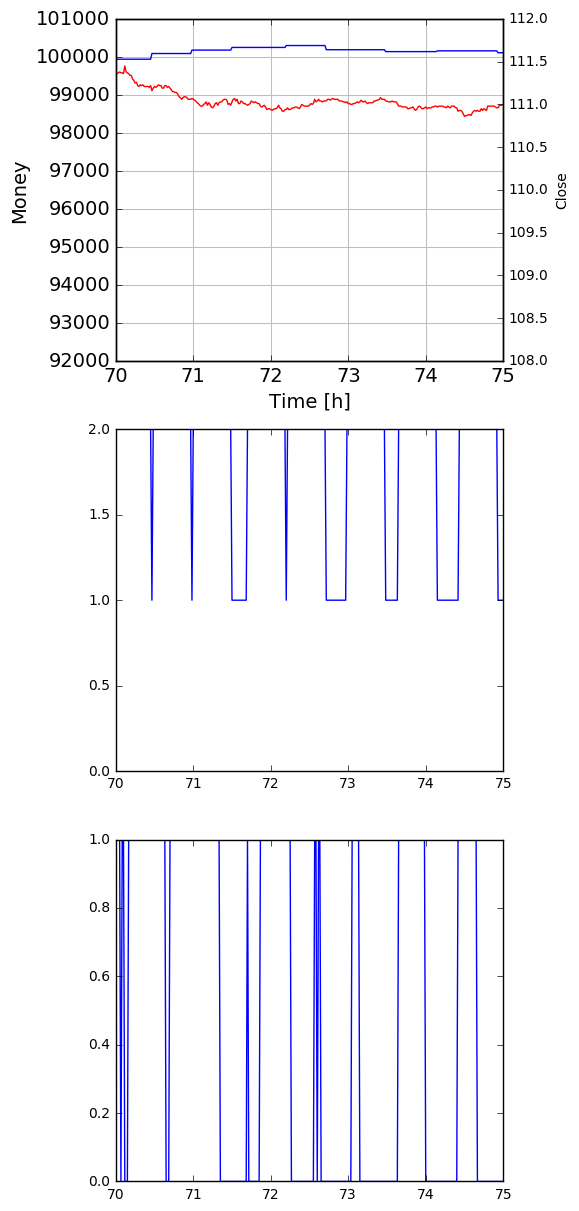

In [153]:
fund_history = bt.get_result().get("fund_history")
flags = bt.get_result().get("flag")

dff.makefig(5,15)
plt.subplot(311)
plt.plot(datetimes[:stop], fund_history[:-1])
dff.arrangefig(xlabel="Time [h]", ylabel="Money")
ax2 = plt.gca().twinx()
plt.plot(datetimes[:stop], close[:stop], "r")
ax2.set_ylabel("Close")
plt.xlim(70, 75)
plt.subplot(312)
plt.plot(datetimes[:stop], flags[:-1])
plt.xlim(70, 75)

plt.subplot(313)
plt.plot(datetimes[:stop], res2[:stop])
plt.xlim(70, 75)

30分後に自動的に切り上げるシステムだと負けるようである。

# バックテストで負けていることを受けて、データを見直す

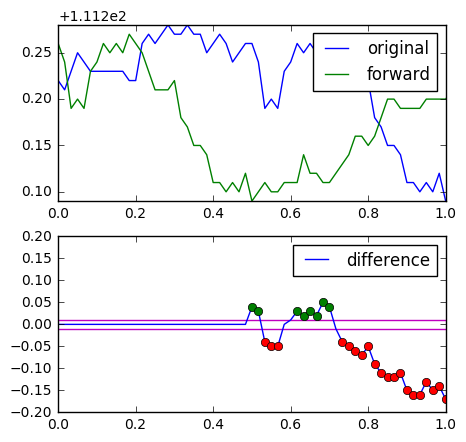

In [34]:
xlim = [0, 1]

dff.makefig(5,5)
plt.subplot(211)
plt.plot(datetimes, close, label="original")

close_forward = np.zeros_like(close)
close_forward[:-30] = close[30:]
plt.plot(datetimes, close_forward, label="forward")
ind = (datetimes>= xlim[0])&(datetimes <= xlim[1])
plt.xlim(xlim)
plt.ylim([close[ind].min(), close[ind].max()])
plt.legend()

plt.subplot(212)
plt.plot(datetimes, diff, label="difference")
plt.plot(datetimes[y[:, 0]== 1], diff[y[:, 0]== 1], "o")
plt.plot(datetimes[y[:, 2]== 1], diff[y[:, 2]== 1], "o")
plt.hlines([-0.01, 0.01], datetimes[0], datetimes[-1], color="m")
plt.xlim(xlim)
plt.ylim(-0.2, 0.2)
plt.legend()


__上記のグラフを見て、教師データの与え方を間違っていることに気づいた。__   
ある時刻 $t$ に立った時に、先の時刻 $t+\tau$ で勝っているかどうかを知りたいのだから、   
先の時刻との差分データ（教師データ）を、時刻 $t+\tau$ ではなく $t$ で与えるべきであった。

## 正しい教師データ

In [38]:
def labeling(M, s, k=1, mode=1):
    """
    Label each value of `M`.
    Labeling follows the below rule:
        * Label 0 (higher):  $M(n+k) - M(n) > s$
        * Label 1 (lose)  : $|M(n+k) - M(n)| < s$
        * Label 2 (lower) :  $M(n+k) - M(n) < -s$
    If a value cannot be labeled for some reasons (e.g. the earlier data are missing),
    they should be set to 1 (lose).

    < Input >
        M: value array to label
        k: step
        s: criterion
        mode: 1=return a 1D array, 2=return a 2D array
    """
    if mode == 1:
        diff = M[k:] - M[:-k]
        output_diff = np.zeros_like(M)
        output_diff[:-k] = diff[:]

        label = np.ones_like(diff)
        label[diff>s] = 0
        label[diff<-s] = 2

        output = np.ones_like(M)
        output[:-k] = label[:]
        return output.copy(), output_diff.copy()
    else:
        diff = M[k:] - M[:-k]
        output_diff = np.zeros_like(M)
        output_diff[:-k] = diff[:]

        label1 = np.zeros((k, 3))
        label1[:, 1] = 1
        label2 = np.zeros((len(diff), 3))
        label2[diff>s, 0] = 1
        label2[np.abs(diff)<=s, 1] = 1
        label2[diff<-s, 2] = 1
        return np.vstack((label2, label1)), output_diff.copy()

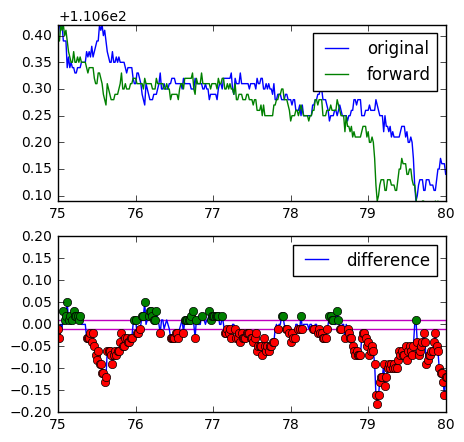

In [42]:
y, diff = labeling(close, s, 30, 2)

xlim = [75, 80]

dff.makefig(5,5)
plt.subplot(211)
plt.plot(datetimes, close, label="original")

close_forward = np.zeros_like(close)
close_forward[:-30] = close[30:]
plt.plot(datetimes, close_forward, label="forward")
ind = (datetimes>= xlim[0])&(datetimes <= xlim[1])
plt.xlim(xlim)
plt.ylim([close[ind].min(), close[ind].max()])
plt.legend()

plt.subplot(212)
plt.plot(datetimes, diff, label="difference")
plt.plot(datetimes[y[:, 0]== 1], diff[y[:, 0]== 1], "o")
plt.plot(datetimes[y[:, 2]== 1], diff[y[:, 2]== 1], "o")
plt.hlines([-0.01, 0.01], datetimes[0], datetimes[-1], color="m")
plt.xlim(xlim)
plt.ylim(-0.2, 0.2)
plt.legend()
